In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.expand_frame_repr', False) 
tickers = ['MASI', 'MSI20', 'ESG10']

year_start = '2021'
year_end   = '2023'

In [114]:
def extract_data(file_path):
    return pd.read_excel(file_path)

folder = 'indices/D' + year_start + '_' + year_end + '/'
ext = '.xls'

folderIMG = 'results/plots/'
png = '.png'

In [115]:
close_df = pd.DataFrame()



for ticker in tickers:
    file = folder + ticker + ext
    data = extract_data(file)
    data = data.set_index('Date')

    close_df[ticker] = data['Dernier']

#log_returns = np.log(close_df / close_df.shift(1))
log_returns = close_df.pct_change()    
log_returns = log_returns.dropna()

In [116]:
portfolio_value = 1_000_000
log_returns


,MASI,MSI20,ESG10
Date,,,
28 déc. 2023,-0.003826,-0.003897,-0.007940
27 déc. 2023,0.004761,0.006452,0.005247
26 déc. 2023,-0.001541,-0.002262,-0.002311
25 déc. 2023,0.005120,0.005791,0.005812
22 déc. 2023,0.002874,0.003003,0.001515
...,...,...,...
8 janv. 2021,-0.004235,-0.004649,-0.004575
7 janv. 2021,0.001963,0.002090,0.005207
6 janv. 2021,-0.004926,-0.006349,-0.008775


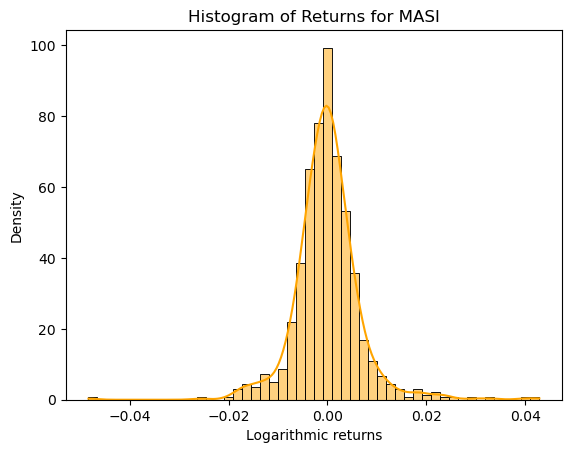

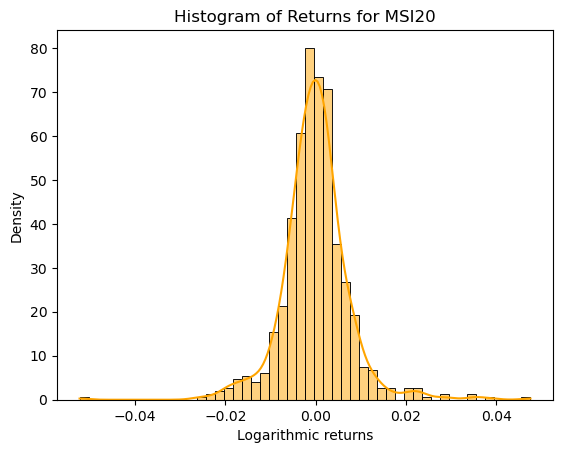

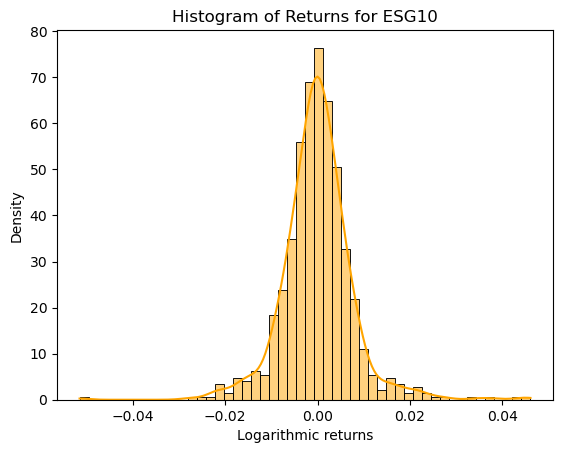

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt


# Supposons que log_returns[ticker] contient vos données de rendements logarithmiques
for ticker in tickers:
    # Créer l'histogramme avec seaborn
    filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
    sns.histplot(filtered_returns, bins=50, kde=True, color='orange', stat='density')

    # Ajouter des étiquettes et un titre
    plt.xlabel('Logarithmic returns')
    plt.ylabel('Density')
    plt.title(f'Histogram of Returns for {ticker}')

    # Afficher le graphique
    plt.savefig(folderIMG+'density_'+ticker+png)
    plt.show()


## Statistics of our samples

In [118]:
from scipy.stats import skew, kurtosis, jarque_bera

statistics = pd.DataFrame(
    index=[
        'Size',
        'Mean',
        'Standard deviation',
        'Skewness',
        'Excess Kurtosis',
        'Jarque-Bera'
    ]
)

for ticker in tickers:
    filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
    statistics[ticker] = [
            len(filtered_returns),
            np.mean(filtered_returns),
            np.std(filtered_returns),
            skew(filtered_returns),
            kurtosis(filtered_returns, fisher=False),
            jarque_bera(filtered_returns)[0]
        ]

print(statistics)

                           MASI        MSI20        ESG10
Size                 751.000000   751.000000   751.000000
Mean                  -0.000063    -0.000056    -0.000024
Standard deviation     0.006731     0.007550     0.007735
Skewness               0.513636     0.403603     0.390894
Excess Kurtosis       12.072876    10.823608    10.196225
Jarque-Bera         2608.860430  1935.715596  1639.584707


## VaRs Calculs

In [119]:
from scipy.optimize import curve_fit

# Fonction de modèle (fonction linéaire)
def linear_model(x, b0, b1):
    return b0 + b1 * x

def gamma(k,x):
    N = len(x)
    som = 0
    for j in range(1,k):
        som += np.log(x[N-j])-np.log(x[N-k-1])
    results = som / k
    return results

deg_freedom = pd.DataFrame(index=['Degrees of Freedom'])
for ticker in tickers:
    filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
    rt = filtered_returns.apply(abs).sort_values()

    # Données pour ajustement (remplacez-les par vos propres données)
    N = len(rt)
    k_values = np.linspace(1,N//2,N//2).astype(int)  # Remplacez ... par les valeurs réelles de k
    gamma_values = [gamma(k,rt) for k in k_values]  # Remplacez ... par les valeurs réelles de gamma

    # Ajustement du modèle
    params, covariance = curve_fit(linear_model, k_values, gamma_values)

    # Récupération des paramètres ajustés
    b0_optimal, b1_optimal = params

    deg_freedom[ticker]= 1/b0_optimal
    #deg_freedom = (1/b0_optimal).astype(int) + 1

deg_freedom

,MASI,MSI20,ESG10
Degrees of Freedom,2.90255,3.093503,3.113557


In [120]:
from scipy.stats import norm,t

    

confidence_levels = [0.950, 0.975, 0.980, 0.985, 0.990, 0.995, 0.999]
var_ntx = ['var-n','var-t','var-x']
col = ['r','b','y']

tableau_var = pd.DataFrame(index=confidence_levels)

for ticker in tickers:
    std = statistics.loc['Standard deviation', ticker]
    mu = statistics.loc['Mean', ticker]
    rt = log_returns[ticker][log_returns[ticker] != 0]
    
    # calcul var_n
    var_n = [ - std * norm.ppf(1-cl) for cl in confidence_levels]
    
    # calcul var_t
    k = np.mean(((rt - mu) / std) ** 2)
    beta = std ** 2 * (k + 3) / (2 * k + 3)
    n = 6 / k + 4
    var_t = [- np.sqrt(beta) * t.ppf(1-cl, n) for cl in confidence_levels]
    
    # calcul var_x
    df = deg_freedom[ticker]['Degrees of Freedom']
    calcul = std / (np.sqrt(df / (df-2)))
    var_x = [- t.ppf(1-cl, df)*calcul for cl in confidence_levels]
    
    # pushing in tab var
    tableau_var[ticker+' var-n'] = var_n
    tableau_var[ticker+' var-t'] = var_t
    tableau_var[ticker+' var-x'] = var_x    

----------------------------Value At Risks----------------------------

                0.950     0.975     0.980     0.985     0.990     0.995     0.999
MASI var-n   0.011072  0.013193  0.013825  0.014608  0.015659  0.017339  0.020801
MASI var-t   0.010912  0.013415  0.014205  0.015217  0.016640  0.019081  0.024948
MASI var-x   0.008956  0.012176  0.013346  0.014970  0.017510  0.022670  0.040293
MSI20 var-n  0.012418  0.014798  0.015506  0.016384  0.017564  0.019447  0.023331
MSI20 var-t  0.012239  0.015046  0.015932  0.017068  0.018663  0.021402  0.027982
MSI20 var-x  0.010435  0.014044  0.015340  0.017127  0.019898  0.025448  0.043864
ESG10 var-n  0.012723  0.015160  0.015886  0.016786  0.017994  0.019924  0.023903
ESG10 var-t  0.012539  0.015415  0.016323  0.017486  0.019121  0.021927  0.028668
ESG10 var-x  0.010726  0.014422  0.015748  0.017575  0.020404  0.026065  0.044794


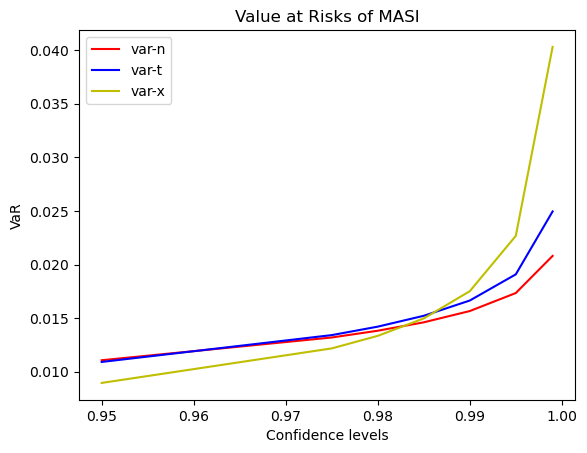

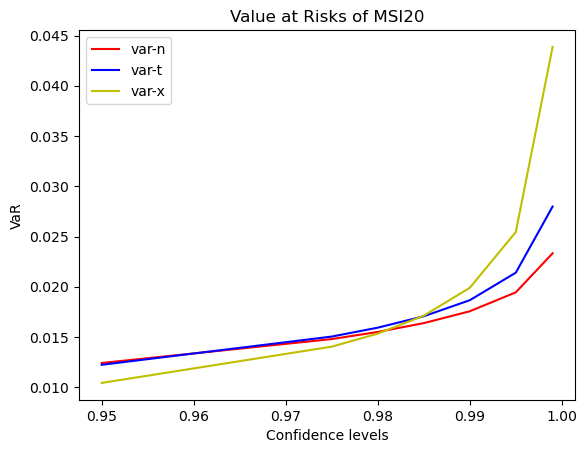

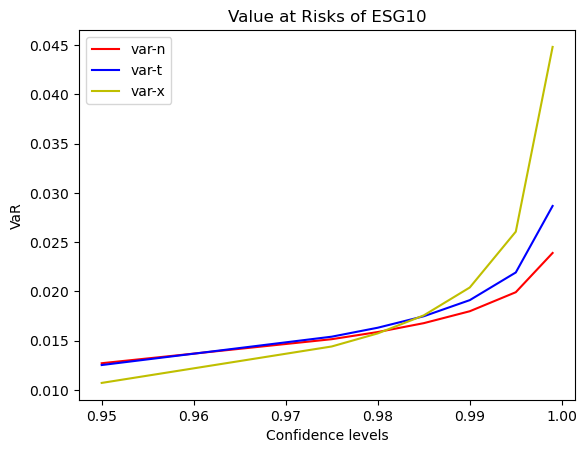

In [121]:
print('----------------------------Value At Risks----------------------------\n')
print(tableau_var.T)

for ticker in tickers :
    for v,c in zip(var_ntx,col) :
        plt.plot(tableau_var[ticker+' '+v],color=c,label=v)
    plt.xlabel('Confidence levels')
    plt.ylabel('VaR')
    plt.title(f'Value at Risks of {ticker}')
    plt.legend()
    plt.savefig(folderIMG+'var_'+ticker+png)
    plt.show()

In [122]:
tab = pd.DataFrame(index=confidence_levels)

for ticker in tickers :
    for v in var_ntx :
        l = []
        for cl in confidence_levels :
            filtered_returns = log_returns[ticker][log_returns[ticker] != 0]
            var = tableau_var[ticker+' '+v][cl]
            tab_ec = [x for x in filtered_returns if x < 0 and x < -var]
            l.append(len(tab_ec) / len(filtered_returns))
        tab[ticker+' '+v] = l

print('----------------------------Failure Rates----------------------------\n')
print(tab.T)

----------------------------Failure Rates----------------------------

                0.950     0.975     0.980     0.985     0.990     0.995     0.999
MASI var-n   0.038615  0.026631  0.023968  0.021305  0.017310  0.009321  0.002663
MASI var-t   0.039947  0.025300  0.023968  0.017310  0.014647  0.003995  0.002663
MASI var-x   0.055925  0.034621  0.026631  0.019973  0.009321  0.002663  0.001332
MSI20 var-n  0.041278  0.030626  0.025300  0.023968  0.017310  0.009321  0.003995
MSI20 var-t  0.043941  0.027963  0.023968  0.019973  0.014647  0.005326  0.001332
MSI20 var-x  0.054594  0.034621  0.026631  0.019973  0.009321  0.002663  0.001332
ESG10 var-n  0.042610  0.029294  0.025300  0.018642  0.014647  0.013316  0.003995
ESG10 var-t  0.043941  0.027963  0.023968  0.017310  0.013316  0.005326  0.001332
ESG10 var-x  0.053262  0.031957  0.027963  0.015979  0.011984  0.002663  0.001332


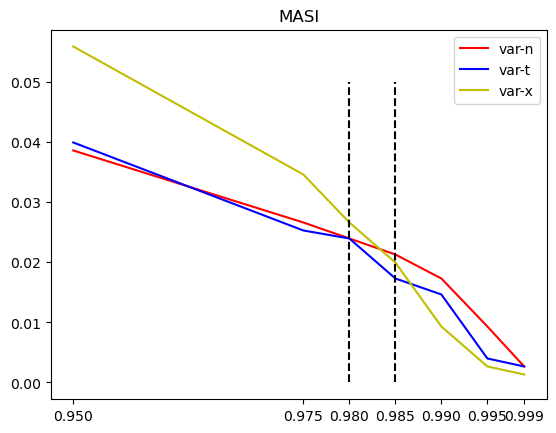

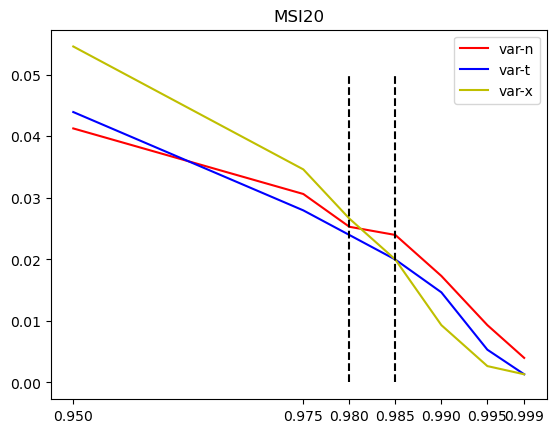

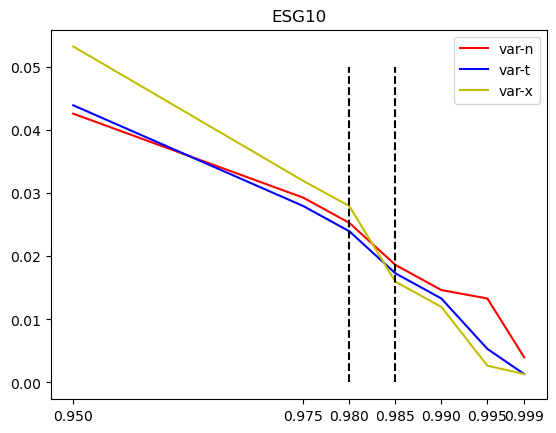

In [130]:
for ticker in tickers :
    for v,c in zip(var_ntx,col) :
        plt.plot(tab[ticker+' '+v],color=c,label=v)

#plt.plot(tab['MASI var-t'],color='b')

    # Repere norme
    y = np.ones(len(confidence_levels))
    y = y - confidence_levels
    # plt.plot(confidence_levels,y,color='g')
    # Recherche de x_change l'intersection entre var-n et var-x
    x_change = 0
    for i in range(len(confidence_levels)):
        if tab[ticker+' var-n'][confidence_levels[i]] > tab[ticker+' var-x'][confidence_levels[i]]:
            x_change = confidence_levels[i-1]
            x_change2 = confidence_levels[i]
            break

    # plot d'une bar en tiré de x
    plt.plot([x_change,x_change],[0,0.05],color='black',linestyle='dashed')
    plt.plot([x_change2,x_change2],[0,0.05],color='black',linestyle='dashed')

    plt.xticks(confidence_levels)
    plt.title(ticker)
    plt.legend()
    plt.savefig(folderIMG+'fr_'+ticker+png)
    plt.show()